# Obesity Level Prediction (UCI 544)

## Goal
Predict the obesity level category (`NObeyesdad`) using eating habits and physical condition features.

## Metrics
Primary: Macro F1-score  
Secondary: Accuracy

## Load the Dataset

We load the dataset directly from the UCI Machine Learning Repository using the `ucimlrepo` package.  


In [5]:
import pandas as pd 
import numpy as np

from ucimlrepo import fetch_ucirepo

# Fetch dataset (UCI ID 544)
obesity = fetch_ucirepo(id=544)

X = obesity.data.features
y = obesity.data.targets

print("X shape:", X.shape)
print("y shape:", y.shape)

display(X.head())
display(y.head())

X shape: (2111, 16)
y shape: (2111, 1)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation


,NObeyesdad
0,Normal_Weight
1,Normal_Weight
2,Normal_Weight
3,Overweight_Level_I
4,Overweight_Level_II


## Combine Features and Target

For exploratory data analysis (EDA), it is convenient to work with a single DataFrame  
that includes both features and the target variable.

This makes it easier to:
- inspect target distribution
- analyze feature–target relationships
- visualize patterns


In [6]:
df = X.copy()
df["NObeyesdad"] = y.iloc[:, 0]

print("Combined DataFrame shape:", df.shape)
print("\nColumn names:")
print(df.columns)

print("\nTarget class distribution:")
print(df["NObeyesdad"].value_counts())


Combined DataFrame shape: (2111, 17)

Column names:
Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

Target class distribution:
NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64


## Inspect Data Types and Missing Values

Before any preprocessing or modeling, it is critical to understand:
- which features are numeric vs categorical
- whether missing values are present

This informs:
- encoding strategies
- imputation choices
- pipeline design


In [7]:
print("Data types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))

print("\nAny missing values in dataset?")
print(df.isna().any().any())


Data types:
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

Missing values per column:
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC            

## Initial Observations

From the initial inspection:

- The dataset contains **2,111 observations** and **17 columns**  
  (16 feature variables and 1 target variable).
- The target variable **`NObeyesdad`** represents a **7-class multi-class classification problem**.
- The class distribution is relatively balanced across obesity categories, with no extreme class imbalance.
- No missing values are present in the dataset, consistent with the dataset documentation.
- The feature set includes a mix of:
  - **Continuous numeric features** (e.g., Age, Height, Weight)
  - **Discrete numeric features** (e.g., FCVC, TUE)
  - **Binary categorical features** encoded as strings (e.g., yes/no)
  - **Multi-class categorical features** (e.g., CAEC, CALC, MTRANS)

These observations inform the preprocessing strategy used later, including feature scaling for numeric variables and one-hot encoding for categorical variables.



## Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand:
- the distribution of the target variable
- basic characteristics of numeric features
- potential relationships that may influence modeling decisions

The goal is to gain intuition while avoiding over-analysis.

### Target Variable Distribution

Understanding the distribution of obesity level classes is important for:
- choosing appropriate evaluation metrics
- identifying potential class imbalance
- motivating the use of macro-averaged metrics


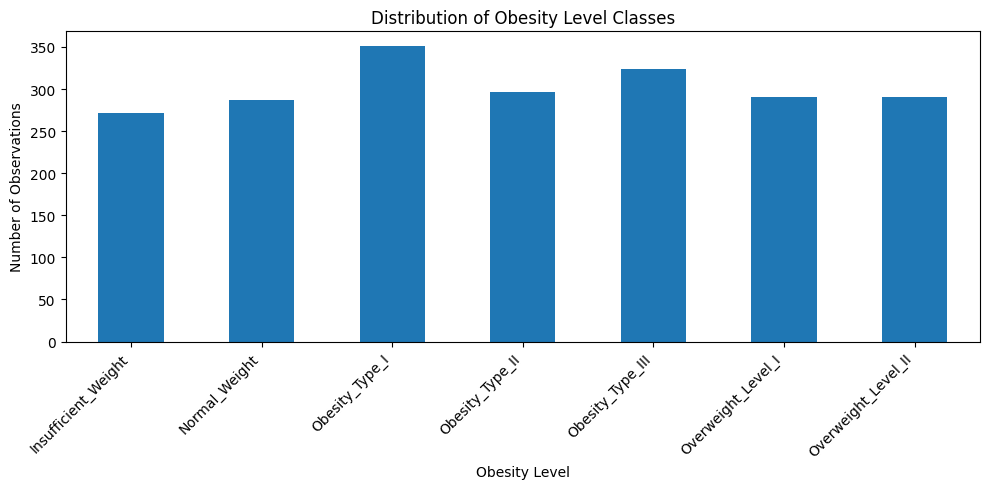

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
df["NObeyesdad"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution of Obesity Level Classes")
plt.xlabel("Obesity Level")
plt.ylabel("Number of Observations")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Numeric Feature Summary

Next we examine summary statistics for numeric features to understand:
- scale differences
- potential outliers
- whether feature scaling will be necessary


In [9]:
numeric_cols = df.select_dtypes(include="number").columns

df[numeric_cols].describe()


,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


### Correlation Between Numeric Features

Correlation analysis helps identify:
- highly correlated variables
- redundant information
- features that may benefit from regularization or tree-based models


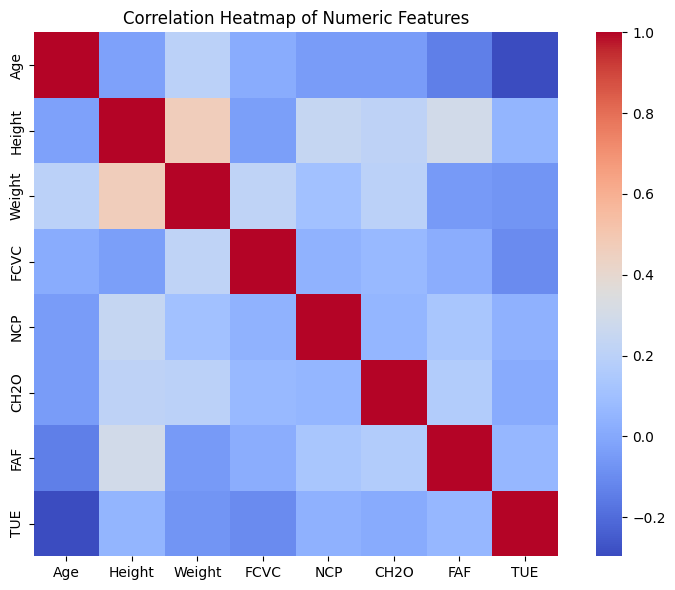

In [10]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    df[numeric_cols].corr(),
    annot=False,
    cmap="coolwarm",
    square=True
)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


## EDA Takeaways

Key insights from the exploratory analysis:

- The target variable (`NObeyesdad`) is **fairly well balanced** across the seven obesity categories, with each class containing roughly 270–350 observations.  
  This supports the use of **macro-averaged evaluation metrics** such as Macro F1-score.

- Numeric features exhibit **substantially different scales**:
  - Age ranges from 14 to 61
  - Height ranges roughly from 1.45 to 1.98
  - Weight ranges from 39 to 173  
  This confirms that **feature scaling is necessary**, particularly for distance-based or linear models.

- Correlation analysis shows:
  - A **moderate positive correlation** between Height and Weight
  - Generally **low to moderate correlations** among most other numeric features  
  This suggests limited multicollinearity overall, while still indicating that some regularization may be beneficial.

- The combination of mixed feature types (numeric, binary categorical, multi-class categorical) and modest correlations motivates:
  - the use of a `ColumnTransformer` for preprocessing
  - comparison of both **regularized linear models** and **tree-based models**, which can capture non-linear relationships without heavy feature interaction engineering.


## Train / Validation / Test Split

Before preprocessing and modeling, we split the data into training, validation, and test sets.

This ensures:
- preprocessing steps are learned only from training data
- hyperparameter tuning does not leak information from the test set
- final evaluation reflects true generalization performance


### Separate Features and Target

We explicitly separate the feature matrix (`X`) and the target vector (`y`)
to avoid accidentally including the target variable in preprocessing steps.


In [11]:
X = df.drop(columns=["NObeyesdad"])
y = df["NObeyesdad"]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2111, 16)
y shape: (2111,)


### Train–Test Split

We first split the dataset into training and test sets.
The test set will be held out and used only once for final evaluation.

Stratification is used to preserve the class distribution across splits.


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 1688
Test set size: 423


### Validation Split

A validation set is created from the training data.
This set will be used for:
- model comparison
- hyperparameter tuning

The test set remains untouched until the final evaluation step.


In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 of total data
    random_state=42,
    stratify=y_train
)

print("Final training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])


Final training set size: 1266
Validation set size: 422
Test set size: 423


### Verify Class Distribution Across Splits

We confirm that stratification preserved the class distribution
across training, validation, and test sets.


In [14]:
def class_distribution(y, name):
    print(f"\n{name} distribution:")
    print(y.value_counts(normalize=True).round(3))

class_distribution(y_train, "Training")
class_distribution(y_val, "Validation")
class_distribution(y_test, "Test")



Training distribution:
NObeyesdad
Obesity_Type_I         0.167
Obesity_Type_III       0.153
Obesity_Type_II        0.141
Overweight_Level_I     0.137
Overweight_Level_II    0.137
Normal_Weight          0.136
Insufficient_Weight    0.129
Name: proportion, dtype: float64

Validation distribution:
NObeyesdad
Obesity_Type_I         0.166
Obesity_Type_III       0.154
Obesity_Type_II        0.140
Overweight_Level_II    0.137
Overweight_Level_I     0.137
Normal_Weight          0.135
Insufficient_Weight    0.130
Name: proportion, dtype: float64

Test distribution:
NObeyesdad
Obesity_Type_I         0.165
Obesity_Type_III       0.154
Obesity_Type_II        0.142
Normal_Weight          0.137
Overweight_Level_II    0.137
Overweight_Level_I     0.137
Insufficient_Weight    0.128
Name: proportion, dtype: float64


### Split Validation and Stratification Check

The class distributions across the training, validation, and test sets are nearly identical.
Each obesity category maintains approximately the same proportion in every split.

This confirms that stratified sampling was successful and ensures that:
- all obesity classes are consistently represented during training and evaluation
- macro-averaged metrics (e.g., Macro F1-score) provide a fair assessment
- model performance comparisons are not biased by class distribution shifts

The test set remains fully untouched and will be used only once for final evaluation.


## Preprocessing

This dataset contains a mix of numeric and categorical variables.
To prepare the data for machine learning models, we build a preprocessing pipeline that:

- imputes missing values (as a safe default, even though the dataset has none)
- scales numeric features for models that are sensitive to feature scale
- one-hot encodes categorical features for compatibility with scikit-learn estimators

We implement this using `ColumnTransformer` so that numeric and categorical features
are processed separately but combined into a single model-ready feature matrix.


### Identify Feature Types

We split features into numeric and categorical columns based on their pandas data types.
This ensures each type receives the appropriate transformations.


In [15]:
import numpy as np

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

print("Number of numeric columns:", len(num_cols))
print("Numeric columns:", num_cols)
print("\nNumber of categorical columns:", len(cat_cols))
print("Categorical columns:", cat_cols)


Number of numeric columns: 8
Numeric columns: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

Number of categorical columns: 8
Categorical columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


### Build Transformation Pipelines

- Numeric features: impute with median (robust) + scale with StandardScaler
- Categorical features: impute with most frequent + one-hot encode

We use `handle_unknown='ignore'` so unseen categories at prediction time do not break inference.


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


### Fit Preprocessor on Training Data Only

To avoid data leakage, we fit preprocessing steps using only the training split.
We then transform the training and validation data to confirm the output shape.


In [17]:
X_train_processed = preprocess.fit_transform(X_train)
X_val_processed = preprocess.transform(X_val)

print("Processed training shape:", X_train_processed.shape)
print("Processed validation shape:", X_val_processed.shape)


Processed training shape: (1266, 23)
Processed validation shape: (422, 23)


### View Transformed Feature Names

After one-hot encoding, the number of features increases.
Inspecting feature names helps later when interpreting feature importance.


In [18]:
# Get feature names out of the ColumnTransformer
ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

all_feature_names = np.concatenate([num_cols, cat_feature_names])

print("Total transformed features:", len(all_feature_names))
print("First 20 feature names:", all_feature_names[:20])


Total transformed features: 23
First 20 feature names: ['Age' 'Height' 'Weight' 'FCVC' 'NCP' 'CH2O' 'FAF' 'TUE' 'Gender_Male'
 'family_history_with_overweight_yes' 'FAVC_yes' 'CAEC_Frequently'
 'CAEC_Sometimes' 'CAEC_no' 'SMOKE_yes' 'SCC_yes' 'CALC_Frequently'
 'CALC_Sometimes' 'CALC_no' 'MTRANS_Bike']


### Preprocessing Summary and Validation

The preprocessing pipeline correctly separates numeric and categorical features and applies
appropriate transformations to each.

Key observations:

- The dataset contains an equal number of numeric (8) and categorical (8) features.
- After preprocessing, the feature space expands from 16 original features to 23 transformed features,
  reflecting one-hot encoding of categorical variables with `drop="first"` applied.
- The transformed training and validation sets have consistent feature dimensions,
  confirming that the preprocessing pipeline generalizes correctly beyond the training data.
- Fitting the preprocessing steps exclusively on the training set avoids data leakage
  and ensures that validation and test evaluations remain unbiased.

This preprocessing setup is compatible with both linear models (which benefit from scaling)
and tree-based models (which can leverage one-hot encoded categorical variables).


## Baseline Model: Logistic Regression

We begin with a baseline multi-class classifier using Logistic Regression.
This model serves as a reference point for evaluating more complex models later.

The baseline uses:
- the preprocessing pipeline defined earlier
- default hyperparameters (except for max iterations)
- Macro F1-score as the primary evaluation metric


### Build Baseline Pipeline

We combine preprocessing and classification into a single scikit-learn `Pipeline`.
This ensures that all transformations are applied consistently during training and evaluation.


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

baseline_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        n_jobs=-1
    ))
])


### Train Baseline Model

The baseline model is trained using only the training set.
The validation set will be used to assess generalization performance.


In [20]:
baseline_pipeline.fit(X_train, y_train)

c:\Users\THE AGAMBISAS\Desktop\Project_IT\obesity-ml-pipeline\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contai

### Baseline Evaluation (Validation Set)

We evaluate the baseline model on the validation set using:
- Macro F1-score (primary metric)
- Accuracy (secondary metric)


In [21]:
from sklearn.metrics import f1_score, accuracy_score

y_val_pred = baseline_pipeline.predict(X_val)

val_f1 = f1_score(y_val, y_val_pred, average="macro")
val_acc = accuracy_score(y_val, y_val_pred)

print("Baseline Validation Macro F1:", round(val_f1, 4))
print("Baseline Validation Accuracy:", round(val_acc, 4))

Baseline Validation Macro F1: 0.8479
Baseline Validation Accuracy: 0.8555


### Baseline Model Performance

The baseline Logistic Regression model achieves strong validation performance:
- **Macro F1-score:** 0.848
- **Accuracy:** 0.856

The close alignment between accuracy and Macro F1-score indicates that the model performs
consistently across all obesity categories rather than favoring a subset of classes.

These results suggest that:
- the preprocessing pipeline is effective
- linear decision boundaries capture a significant portion of the underlying signal
- more complex models may still provide gains by modeling non-linear relationships

This baseline establishes a solid reference point for subsequent model comparisons.


## Model Comparison

After establishing a strong baseline with Logistic Regression, we compare its performance
against more expressive models that can capture non-linear relationships.

All models:
- use the same preprocessing pipeline
- are evaluated on the validation set
- are compared using Macro F1-score and Accuracy


### Candidate Models

We evaluate the following models:

- **Logistic Regression** (baseline, linear)
- **Random Forest Classifier** (non-linear, tree-based)
- **Gradient Boosting Classifier** (ensemble boosting)

These models represent increasing levels of complexity.


In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

models = {
    "LogisticRegression": LogisticRegression(
        max_iter=2000,
        n_jobs=-1
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    )
}

### Train and Evaluate Models

Each model is trained using the training set and evaluated on the validation set.


In [23]:
from sklearn.metrics import f1_score, accuracy_score

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("clf", model)
    ])
    
    pipe.fit(X_train, y_train)
    y_val_pred = pipe.predict(X_val)
    
    f1 = f1_score(y_val, y_val_pred, average="macro")
    acc = accuracy_score(y_val, y_val_pred)
    
    results.append({
        "Model": name,
        "Validation Macro F1": round(f1, 4),
        "Validation Accuracy": round(acc, 4)
    })

results_df = pd.DataFrame(results).sort_values(
    by="Validation Macro F1", ascending=False
)

results_df


c:\Users\THE AGAMBISAS\Desktop\Project_IT\obesity-ml-pipeline\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,Model,Validation Macro F1,Validation Accuracy
2,Gradient Boosting,0.9437,0.9455
1,Random Forest,0.9365,0.9384
0,LogisticRegression,0.8479,0.8555


### Model Comparison Results

The comparison reveals clear performance differences between model families:

- Tree-based ensemble models substantially outperform the linear baseline.
- **Gradient Boosting** achieves the strongest validation performance with:
  - **Macro F1-score:** 0.944
  - **Accuracy:** 0.946
- Random Forest also performs well, but slightly below Gradient Boosting.
- Logistic Regression, while strong as a baseline, underperforms relative to models
  capable of capturing non-linear relationships and feature interactions.

These results indicate that obesity level prediction benefits from modeling
non-linear patterns in lifestyle and physical condition features.

Based on validation performance, **Gradient Boosting** is selected as the leading
candidate for hyperparameter tuning.


## Hyperparameter Tuning

After identifying Gradient Boosting as the strongest candidate during model comparison,
we perform hyperparameter tuning to further improve performance.

Randomized search is used to efficiently explore the hyperparameter space while
optimizing for Macro F1-score.


### Gradient Boosting Pipeline for Tuning

The preprocessing pipeline is combined with the Gradient Boosting classifier
to ensure that all transformations are applied consistently during cross-validation.


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

gb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", GradientBoostingClassifier(random_state=42))
])


### Hyperparameter Search Space

We tune a focused set of hyperparameters that strongly influence
model complexity and generalization performance.


In [25]:
param_dist = {
    "clf__n_estimators": [100, 150, 200, 300],
    "clf__learning_rate": [0.05, 0.1, 0.2],
    "clf__max_depth": [2, 3, 4],
    "clf__subsample": [0.8, 1.0]
}


### Run Randomized Search

Randomized search evaluates a subset of hyperparameter combinations using
cross-validation on the training data.


In [26]:
from sklearn.model_selection import RandomizedSearchCV

gb_search = RandomizedSearchCV(
    estimator=gb_pipeline,
    param_distributions=param_dist,
    n_iter=15,
    scoring="f1_macro",
    cv=5,
    random_state=42,
    n_jobs=-1
)

gb_search.fit(X_train, y_train)


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'clf__learning_rate': [0.05, 0.1, ...], 'clf__max_depth': [2, 3, ...], 'clf__n_estimators': [100, 150, ...], 'clf__subsample': [0.8, 1.0]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",15
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'f1_macro'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be u

### Best Hyperparameters and Validation Performance


In [27]:
print("Best parameters:")
print(gb_search.best_params_)

print("\nBest cross-validated Macro F1:")
print(round(gb_search.best_score_, 4))


Best parameters:
{'clf__subsample': 0.8, 'clf__n_estimators': 300, 'clf__max_depth': 3, 'clf__learning_rate': 0.2}

Best cross-validated Macro F1:
0.9646


### Hyperparameter Tuning Results

Hyperparameter tuning leads to a substantial improvement in model performance.

The best Gradient Boosting configuration achieves a **cross-validated Macro F1-score of 0.965**,
improving upon the untuned model and significantly outperforming the baseline.

Key characteristics of the optimal model include:
- a larger number of estimators (300) to improve representational capacity
- moderate tree depth (max_depth = 3) to control overfitting
- subsampling (0.8) to introduce regularization
- a higher learning rate (0.2) balanced by the increased ensemble size

These results indicate that the tuned Gradient Boosting model effectively captures
non-linear relationships while maintaining strong generalization performance.


## Final Evaluation on Test Set

In this final step, we evaluate the tuned Gradient Boosting model on the held-out test set.
This provides an unbiased estimate of real-world generalization performance.

The test set has not been used during:
- preprocessing fitting
- model training
- model selection
- hyperparameter tuning


### Load Best Tuned Model


In [28]:
best_model = gb_search.best_estimator_

### Test Set Performance

We evaluate the final model using:
- Macro F1-score (primary metric)
- Accuracy (secondary metric)


In [29]:
from sklearn.metrics import f1_score, accuracy_score

y_test_pred = best_model.predict(X_test)

test_f1 = f1_score(y_test, y_test_pred, average="macro")
test_acc = accuracy_score(y_test, y_test_pred)

print("Test Macro F1:", round(test_f1, 4))
print("Test Accuracy:", round(test_acc, 4))

Test Macro F1: 0.9476
Test Accuracy: 0.948


### Confusion Matrix

The confusion matrix provides insight into which obesity categories
are most frequently confused by the model.


<Figure size 800x800 with 0 Axes>

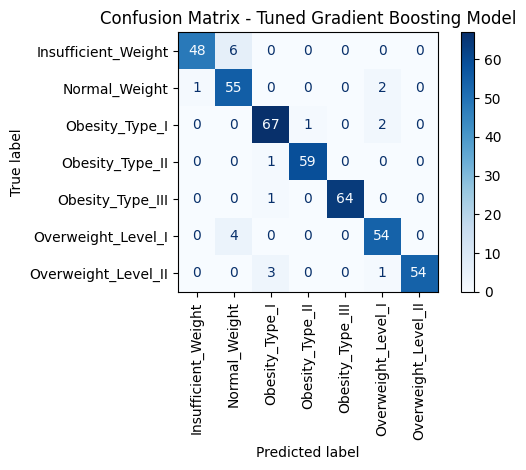

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    xticks_rotation=90,
    cmap="Blues"
)

plt.title("Confusion Matrix - Tuned Gradient Boosting Model")
plt.tight_layout()
plt.show()

### Final Test Set Performance

The tuned Gradient Boosting model achieves strong performance on the held-out test set:
- **Macro F1-score:** 0.948
- **Accuracy:** 0.948

The close alignment between validation and test performance indicates strong generalization
and minimal overfitting.

The confusion matrix shows that most predictions fall along the diagonal, with occasional
misclassifications occurring primarily between adjacent obesity categories. This behavior
is expected given the gradual nature of obesity level transitions and suggests that the
model captures meaningful structure in the data.


## Conclusion and Next Steps

### Summary
This project demonstrates an end-to-end machine learning workflow for predicting obesity
levels using lifestyle and physical condition data.

Key achievements include:
- building a leakage-safe preprocessing and modeling pipeline
- establishing a strong baseline and systematically improving performance
- selecting and tuning a Gradient Boosting model
- achieving robust generalization on an unseen test set

### Limitations
- The dataset includes a significant proportion of synthetically generated samples.
- Feature importance and interpretability could be explored further.

### Future Work
- Perform feature importance analysis or SHAP-based interpretation
- Explore alternative boosting algorithms (e.g., XGBoost, LightGBM)
- Package the trained pipeline for real-time inference
- Add model monitoring and data drift checks for production use
